In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, dates

In [2]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

In [21]:
gmx_arb = pd.read_csv('data/GMX_Arbitrum_Fees_2021-08-31_2022-07-05.csv')
gmx_avax = pd.read_csv('data/GMX_Avax_Fees_2022-01-06_2022-07-05.csv')
gmx_price_raw = pd.read_csv('data/gmx-usd-price.csv')
gmx_arb_staked = pd.read_csv('data/gmx_staked_arbi.csv')
gmx_avax_staked = pd.read_csv('data/gmx_staked_avax.csv')
eth_price = pd.read_csv('data/eth-usd-max.csv')
gmx_arb.head()

,Date,Swap,Margin trading,Mint GLP,Burn GLP,Liquidation,Cumulative
0,2021-08-31,0.399321,0.153256,0.118304,0.206160,0.0,0.877041
1,2021-09-01,866.365339,101.848845,4843.226667,0.033713,0.0,5812.351605
2,2021-09-02,854.002762,741.708859,1610.527787,134.264965,0.0,9152.855978
3,2021-09-03,1388.241363,3127.266851,22.380404,0.000000,0.0,13690.744595
4,2021-09-04,219.024733,768.756821,82.883759,0.000000,0.0,14761.409908


<AxesSubplot:title={'center':'Weekly GMX Revenue Avax'}, xlabel='Week', ylabel='Revenue'>

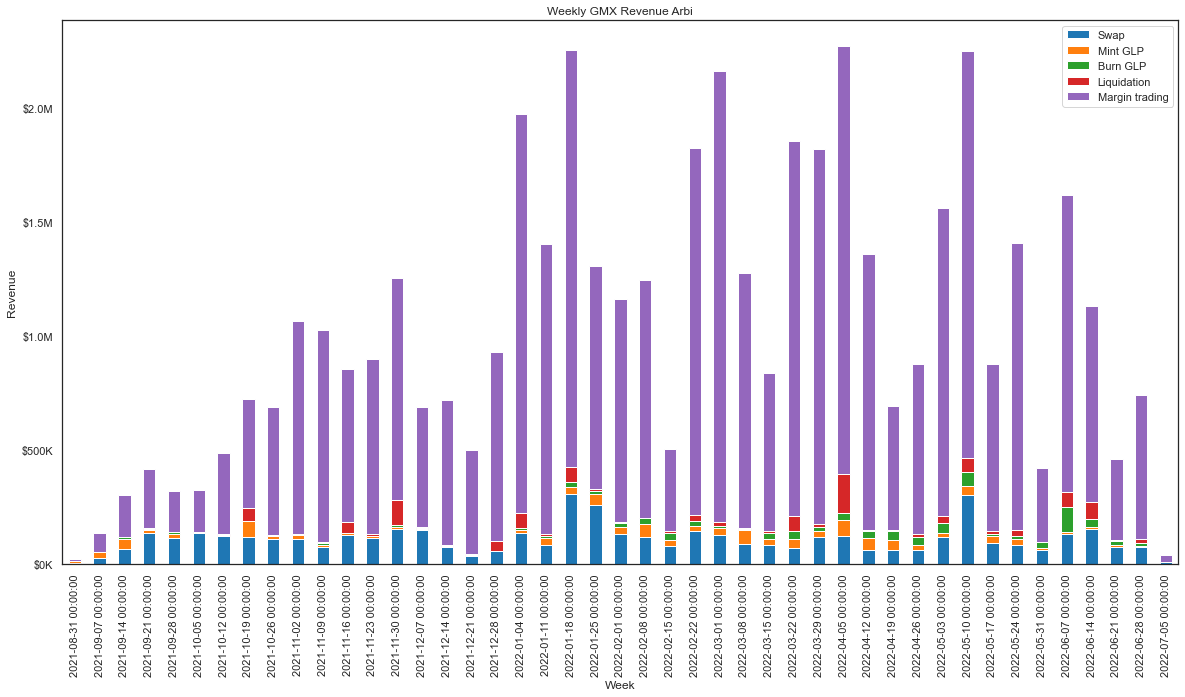

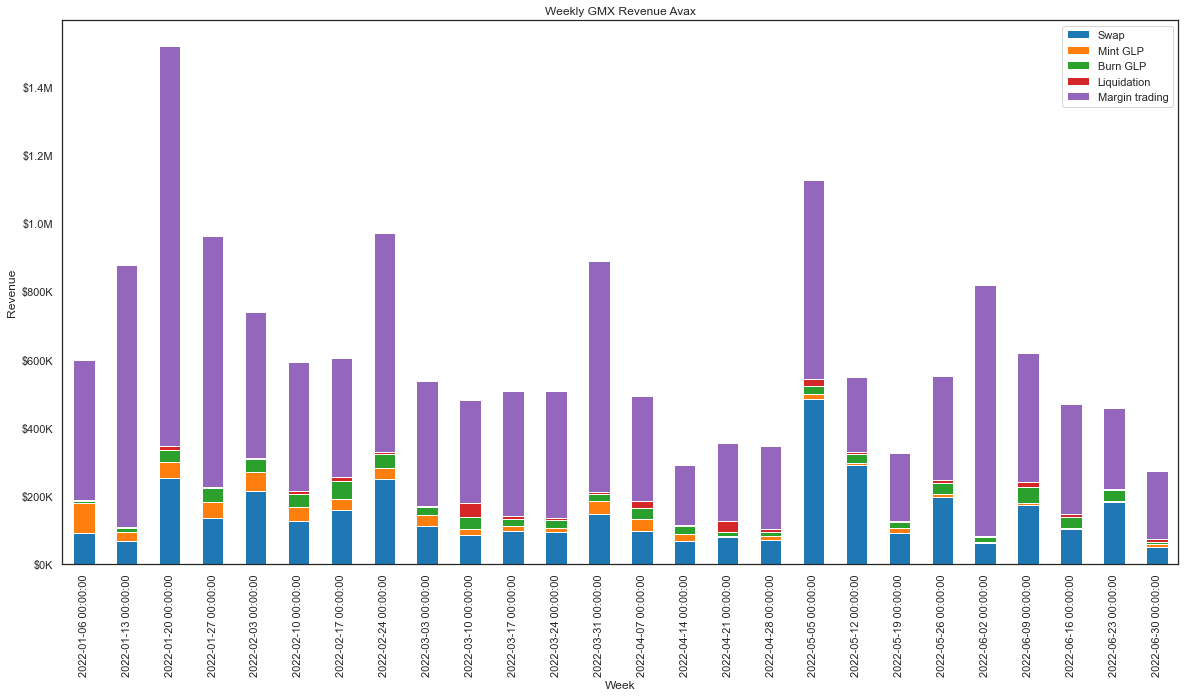

In [67]:
plt.rcParams["figure.figsize"] = [20, 10]
# plt.rcParams.update({'font.size': 50})
sns.set_theme(style="white", palette=None)

def weekly_chain_rev(chain, gmx_data):
    gmx_data.index = pd.to_datetime(gmx_data['Date'])
    gmx_data_res = gmx_data.resample('7D').sum()

    cum_fee = gmx_data_res[['Swap',  'Mint GLP', 'Burn GLP', 'Liquidation','Margin trading']].plot(kind='bar', stacked=True)
    cum_fee.set( 
           xlabel='Week', 
           ylabel='Revenue',
           title=f'Weekly GMX Revenue {chain}')
    cum_fee.yaxis.set_major_formatter(currency)
    # cum_fee_arb.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
    return cum_fee

weekly_chain_rev('Arbi', gmx_arb)
weekly_chain_rev('Avax', gmx_avax)

,Date,Swap,Margin trading,Mint GLP,Burn GLP,Liquidation,Cumulative
0,2022-01-06,243.731498,1841.619851,46512.034412,61.256909,0.111774,4.865875e+04
1,2022-01-07,8361.350661,8681.586268,5877.247515,1085.867040,1456.046912,7.412085e+04
2,2022-01-08,12425.608911,12073.865951,3506.106376,957.728451,422.364682,1.035065e+05
3,2022-01-09,13572.463907,79978.143009,4695.073079,181.761533,0.624591,2.019346e+05
4,2022-01-10,23276.360026,128402.302896,4230.024692,242.779077,425.566029,3.585116e+05
...,...,...,...,...,...,...,...
176,2022-07-01,18111.606685,49224.103433,165.863430,1587.822941,1757.887105,1.633786e+07
177,2022-07-02,1733.926201,14223.760698,129.582623,10.579650,1.024002,1.635396e+07
178,2022-07-03,7596.567502,23309.098000,468.168532,267.875061,3.776040,1.638560e+07
179,2022-07-04,7768.291149,44067.382693,208.239270,358.921068,184.233508,1.643819e+07


In [41]:
eth_price = pd.read_csv('data/eth-usd-max.csv')
gmx_price_raw = pd.read_csv('data/gmx-usd-price.csv')

gmx_price_raw.index = pd.to_datetime(gmx_price_raw['Date'])
gmx_price_raw.index = gmx_price_raw.index.tz_localize(None)
gmx_price = gmx_price_raw.drop(['Date'], axis=1)

eth_price.index = pd.to_datetime(eth_price['snapped_at'])
eth_price.index = eth_price.index.tz_localize(None)
eth_price = eth_price.drop(['snapped_at'], axis=1)
eth_price. rename(columns = {'price':'price_eth'}, inplace = True)

def gmx_yield(gmx_data, chain_staked_table, chain, eth_price):
    
    gmx_total_fee = pd.DataFrame(gmx_data.set_index('Date').drop(['Cumulative'], axis=1).sum(axis=1)*0.3)
    gmx_total_fee.columns = ['GMX_fee']
    
    chain_staked_table['time'] = pd.to_datetime(chain_staked_table['time'], unit='s')
    chain_staked_table = chain_staked_table.sort_values(by=['time']).set_index('time').resample('1D').mean().dropna()
    

    master_df = pd.merge(gmx_price, gmx_total_fee, left_index=True, right_index=True)
    master_df = pd.merge(chain_staked_table[['balance']], master_df, left_index=True, right_index=True)
    master_df = pd.merge(eth_price[['price_eth']], master_df, left_index=True, right_index=True)

    
    master_df['E_coin_d'] = master_df.GMX_fee / master_df.balance
    master_df['E_coin_ann'] = master_df['E_coin_d']*365
    master_df['P/E'] = master_df.price/master_df.E_coin_ann
    master_df['ARR'] = master_df.E_coin_ann/master_df.price

    if chain == 'avax':
        master_df = master_df[(master_df.index > '2022-02-01')]
    
    return master_df


arbi_data = gmx_yield(gmx_arb, gmx_arb_staked, 'arbi', eth_price)
avax_data = gmx_yield(gmx_avax, gmx_avax_staked, 'avax', eth_price)
arbi_data

,price_eth,balance,price,GMX_fee,E_coin_d,E_coin_ann,P/E,ARR
2021-09-13,3417.839367,5.680171e+06,15.732550,6627.822342,0.001167,0.425895,36.939990,0.027071
2021-09-14,3301.186777,5.800790e+06,15.732550,5437.045701,0.000937,0.342112,45.986510,0.021746
2021-09-15,3425.250873,5.821861e+06,21.062166,7664.007147,0.001316,0.480493,43.834507,0.022813
2021-09-16,3595.962571,5.847616e+06,22.646664,10036.232557,0.001716,0.626448,36.150935,0.027662
2021-09-17,3573.307516,5.859065e+06,20.643008,9600.384627,0.001639,0.598072,34.515951,0.028972
...,...,...,...,...,...,...,...,...
2022-07-01,1057.630999,6.204407e+06,15.338699,36373.379847,0.005863,2.139815,7.168236,0.139504
2022-07-02,1068.819440,6.206320e+06,15.793477,12835.242511,0.002068,0.754854,20.922569,0.047795
2022-07-03,1068.541503,6.217913e+06,16.148953,11795.073608,0.001897,0.692387,23.323594,0.042875
2022-07-04,1074.607318,6.223850e+06,16.461406,34958.561609,0.005617,2.050158,8.029335,0.124543


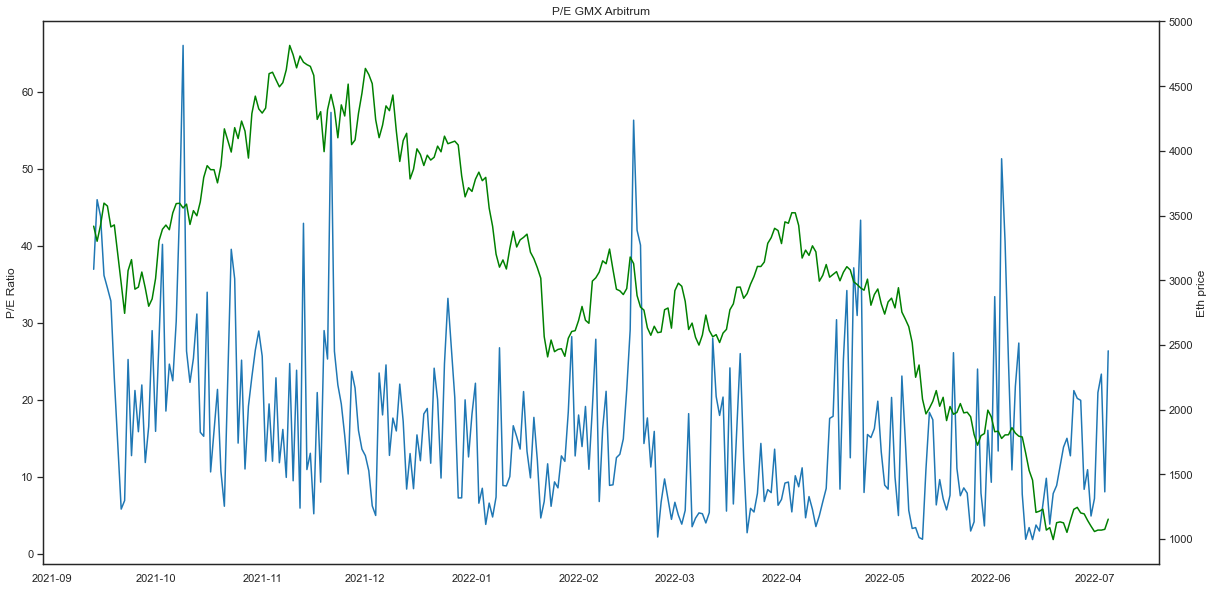

In [68]:
plt.plot(arbi_data.index, arbi_data['P/E'])
plt.title('P/E GMX Arbitrum')
plt.ylabel('P/E Ratio')
eth_p = plt.twinx()
eth_p.plot(arbi_data.index, arbi_data['price_eth'], color='green')
eth_p.set_ylabel('Eth price')
plt.show()

# plt.plot(avax_data.index, avax_data['P/E'], color='green')
# plt.title('P/E GMX Avax')
# plt.ylabel('P/E Ratio')
# plt.show()

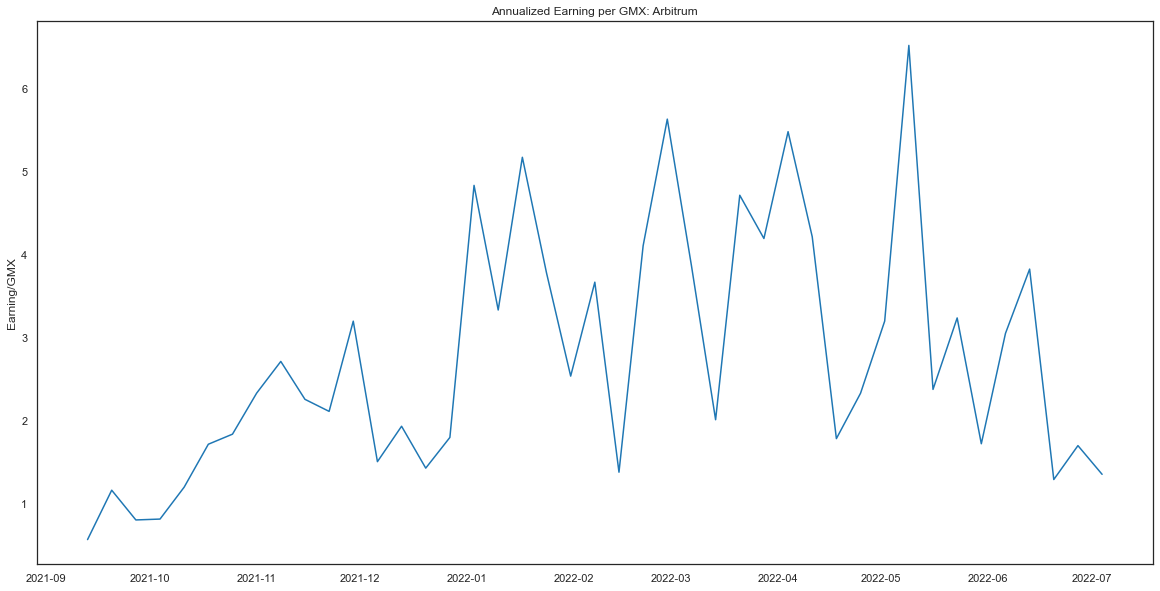

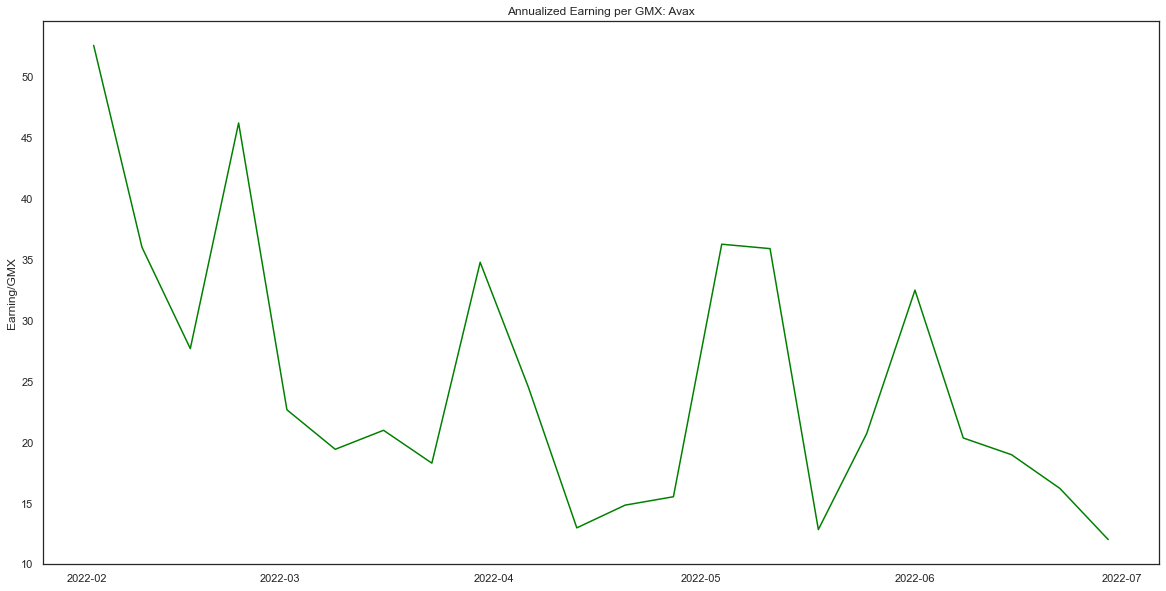

In [11]:
plt.plot(arbi_data.index, arbi_data['E_coin_ann'])
plt.title('Annualized Earning per GMX: Arbitrum')
plt.ylabel('Earning/GMX')
plt.show()

plt.plot(avax_data.index, avax_data['E_coin_ann'], color='green')
plt.title('Annualized Earning per GMX: Avax')
plt.ylabel('Earning/GMX')
plt.show()

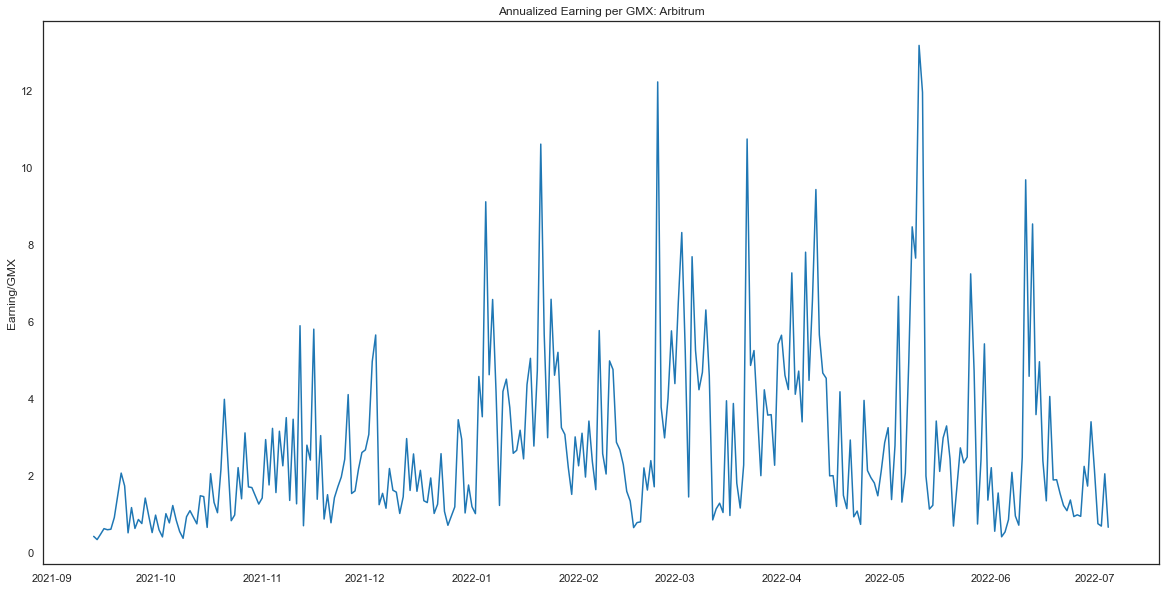

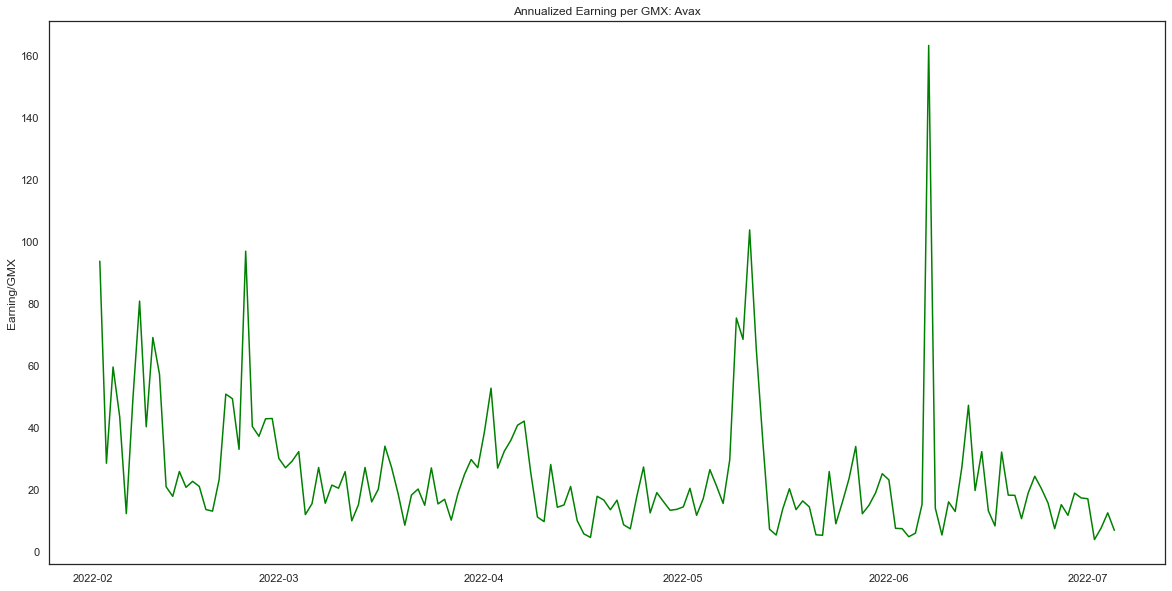

In [8]:
plt.plot(arbi_data.index, arbi_data['E_coin_ann'])
plt.title('Annualized Earning per GMX: Arbitrum')
plt.ylabel('Earning/GMX')
plt.show()

plt.plot(avax_data.index, avax_data['E_coin_ann'], color='green')
plt.title('Annualized Earning per GMX: Avax')
plt.ylabel('Earning/GMX')
plt.show()

In [281]:
### I THINK THIS IS WRONG////

gmx_price_raw.index = pd.to_datetime(gmx_price_raw['Date'])
gmx_price_raw.index = gmx_price_raw.index.tz_localize(None)
gmx_price = gmx_price_raw.drop(['Date'], axis=1)

def gmx_yield(gmx_data, chain_staked_table, chain):
    
    gmx_total_fee = pd.DataFrame(gmx_data.set_index('Date').drop(['Cumulative'], axis=1).sum(axis=1)*0.3)
    gmx_total_fee.columns = ['GMX_fee']
    
    chain_staked_table['time'] = pd.to_datetime(chain_staked_table['time'], unit='s')
    chain_staked_table = chain_staked_table.sort_values(by=['time']).set_index('time').resample('1D').mean().dropna()

    master_df = pd.merge(gmx_price, gmx_total_fee, left_index=True, right_index=True)
    master_df = pd.merge(chain_staked_table[['balance']], master_df, left_index=True, right_index=True)
    
    master_df['usd_balance'] = master_df.balance*master_df.price
    master_df['yield'] = master_df.GMX_fee/master_df.usd_balance
    master_df['ARR'] = (((1 + master_df['yield'])**365)-1)
    master_df['P/E'] = master_df.price/(master_df.price*master_df.ARR)

    if chain == 'avax':

        master_df = master_df[(master_df.index > '2022-02-01')]
    
    pe_table_week = master_df[['P/E']]
    yield_table_week = master_df[['ARR']]
    

    return pe_table_week, yield_table_week, master_df


# gmx_yield(gmx_arb, gmx_arb_staked)[1]
gmx_yield(gmx_avax, gmx_avax_staked, 'avax')[2]

Index(['block', 'balance'], dtype='object')
c


,balance,price,GMX_fee,usd_balance,yield,ARR,P/E
2022-02-02,294141.192546,43.181060,75326.930779,1.270133e+07,0.005931,7.656303,0.130611
2022-02-03,292701.255355,37.585107,22898.322588,1.100121e+07,0.002081,1.136000,0.880282
2022-02-04,300458.874346,37.494671,49109.723951,1.126561e+07,0.004359,3.892348,0.256914
2022-02-05,302483.812940,44.704511,36041.832893,1.352239e+07,0.002665,1.642054,0.608993
2022-02-06,298253.897150,45.656521,9752.063033,1.361724e+07,0.000716,0.298622,3.348720
...,...,...,...,...,...,...,...
2022-06-01,400561.180274,20.484129,25391.213348,8.205147e+06,0.003095,2.088747,0.478756
2022-06-02,403353.939635,18.639521,8270.704000,7.518324e+06,0.001100,0.493774,2.025217
2022-06-03,406522.956523,20.701032,8230.132178,8.415445e+06,0.000978,0.428733,2.332454
2022-06-04,405623.213557,21.281999,5301.273228,8.632473e+06,0.000614,0.251172,3.981335
